In [408]:
%load_ext autoreload
%autoreload 2

from mcmc_lotte import *
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import csv
import pandas as pd
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
test_name = 'lotte_test'

In [299]:
c_matrix = conn_matrix_basic(10)
multi_metropolis(1, 2000, 20, 10, c_matrix)
temperatures = np.linspace(0.5, 50, 50)

In [300]:

means_mag, stds_mag, means_sus, stds_sus = run_simulation(1, 5000, temperatures, 10, c_matrix)

In [301]:
ns = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
tcs = []
peaks = []
for n in ns:
    c_matrix = conn_matrix_basic(n)
    means_mag, stds_mag, means_sus, stds_sus = run_simulation(10, 5000, temperatures, n, c_matrix)
    idx = np.argmax(means_sus)
    tcs.append(temperatures[idx])
    peaks.append(means_sus[idx])


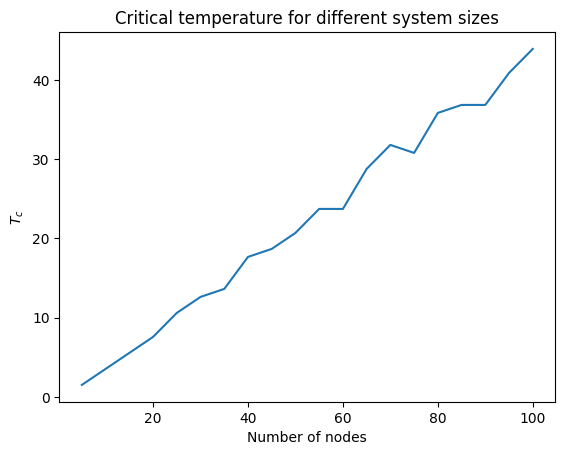

In [310]:
plt.plot(ns, tcs)
plt.xlabel('Number of nodes')
plt.ylabel(r'$T_c$')
plt.title('Critical temperature for different system sizes')
plt.savefig('critical_t_system_size.png')

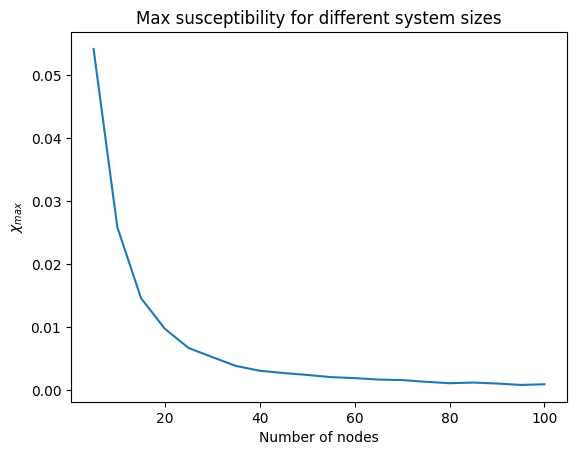

In [311]:
plt.plot(ns, peaks)
plt.xlabel('Number of nodes')
plt.ylabel(r'$\chi_{max}$')
plt.title('Max susceptibility for different system sizes')
plt.savefig('max_sus_system_size.png')

In [312]:
results = powerlaw.Fit(peaks)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare( 'power_law',  'lognormal')
R, p

Calculating best minimal value for power law fit
1.8079007801133449
0.001042237898856399


(-0.11902514972443973, 0.7343413692684896)

In [313]:
with open('DTI_avg_log.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    data = list(reader)
DTI_log = pd.DataFrame(data, dtype = 'float64')
dti_c_matrix = DTI_log.values

In [379]:
n = 90
temperatures = np.linspace(5, 50, 70)
sim_data = run_simulation(70, 10000, temperatures, n, dti_c_matrix)
idx = np.argmax(sim_data[2])
temperatures[idx]

21.304347826086957

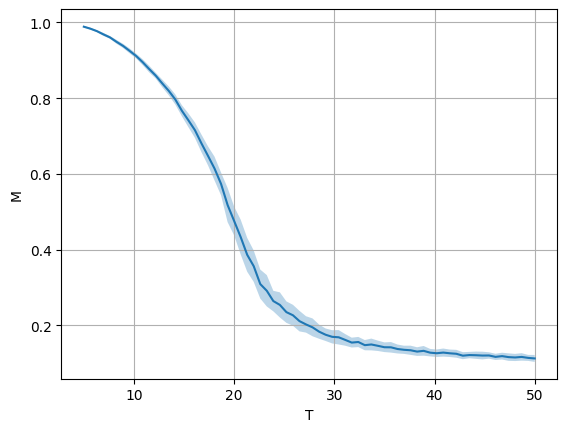

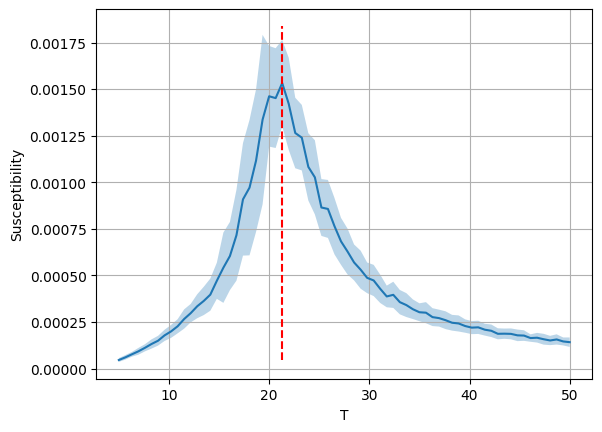

In [380]:
plot_results(sim_data, temperatures, 'DTI', save=True)


In [76]:
with open('fMRI_avg.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    data = list(reader)
fMRI = pd.DataFrame(data, dtype = 'float64')
fmri_c_matrix = fMRI.values
n = 90

In [95]:
temperatures = np.linspace(0.01, 50, 50)
sim_data = run_simulation(30, 5000, temperatures, n, fmri_c_matrix)

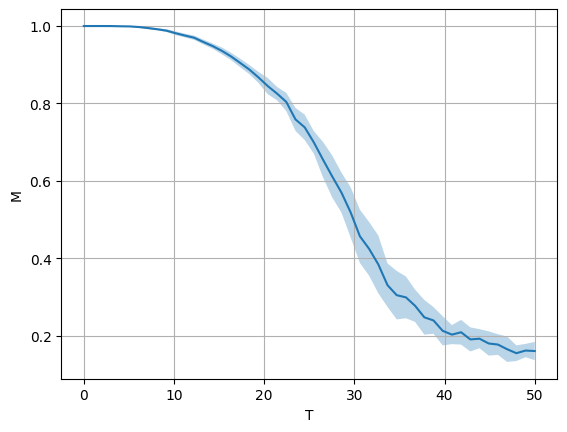

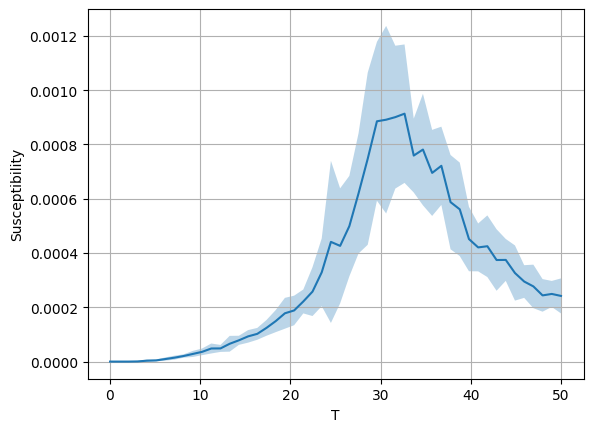

In [96]:
plot_results(sim_data, temperatures, test_name, save=False)

In [370]:
n = 10
n_iterations = 5000
temperatures = np.linspace(1, 30, 30)
J = conn_matrix_basic(n)

sim_data = run_simulation(30, n_iterations, temperatures, n, J)
idx = np.argmax(sim_data[2])
tc = temperatures[idx]

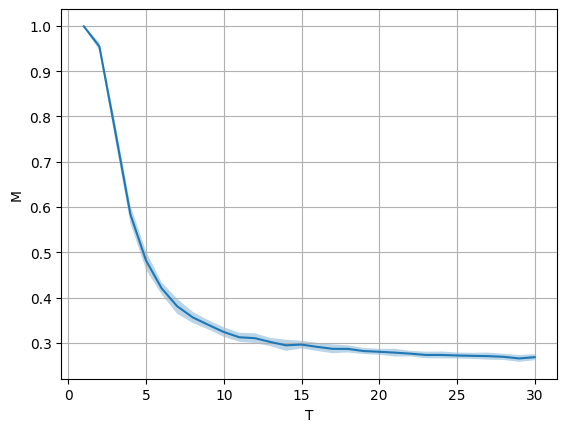

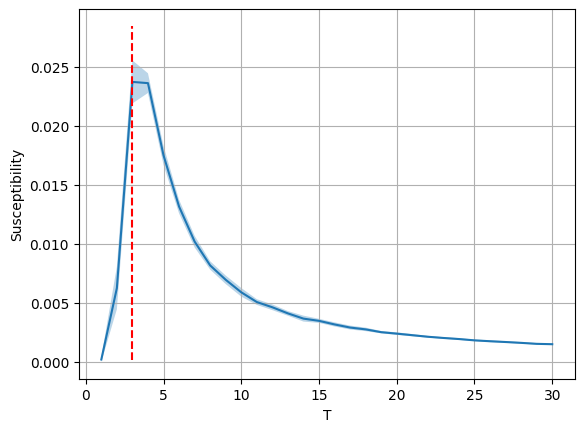

In [371]:
plot_results(sim_data, temperatures, 'DTI', save=False)


In [372]:
runs = 10
combos = list(itertools.product([-1, 1], repeat=3))
C = []
C_std = []


for T in temperatures:
    x = np.zeros(runs)
    for i in range(0, runs):
        spins = random_spins(n)        
        _, list_avg_magnetisation, list_sus, spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[i] = TE(spins_timeseries, n, combos)
    C_std.append(np.std(x))
    C.append(np.abs(np.mean(x)))

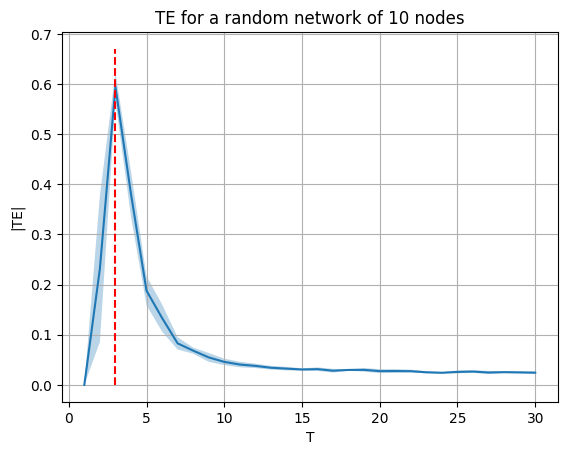

In [374]:
temperatures = np.linspace(1, 30, 30)
lower_bound = np.subtract(C, C_std)
upper_bound = np.add(C, C_std)
plt.plot(temperatures, C)
plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)

plt.ylabel('|TE|')
plt.xlabel('T')
plt.grid()
plt.title('TE for a random network of 10 nodes')
plt.vlines(tc, 0, 0.67, linestyles='dashed', colors='r')
plt.savefig('10_nodes_TE.png', bbox_inches='tight')

In [390]:
n = 10
n_iterations = 5000
temperatures = np.linspace(1, 30, 30)
J = conn_matrix_not_so_basic(n, 0.3)

sim_data = run_simulation(30, n_iterations, temperatures, n, J)
idx = np.argmax(sim_data[2])
tc = temperatures[idx]

In [386]:
runs = 5
combos = list(itertools.product([-1, 1], repeat=3))
C = []
C_std = []


for T in temperatures:
    x = np.zeros(runs)
    for i in range(0, runs):
        spins = random_spins(n)        
        _, list_avg_magnetisation, list_sus, spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[i] = TE(spins_timeseries, n, combos)
    C_std.append(np.std(x))
    C.append(np.abs(np.mean(x)))

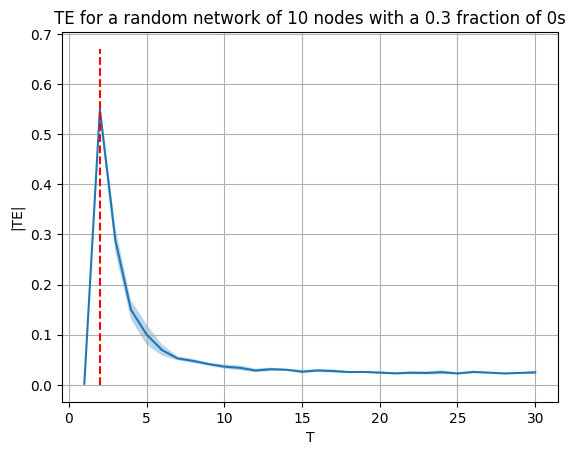

In [392]:
temperatures = np.linspace(1, 30, 30)
lower_bound = np.subtract(C, C_std)
upper_bound = np.add(C, C_std)
plt.plot(temperatures, C)
plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)

plt.ylabel('|TE|')
plt.xlabel('T')
plt.grid()
plt.title('TE for a random network of 10 nodes with a 0.3 fraction of 0s')
plt.vlines(tc, 0, 0.67, linestyles='dashed', colors='r')
# plt.savefig('10_nodes_TE.png', bbox_inches='tight')

In [409]:
TE(spins_timeseries, n, combos)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.CallConstraint object at 0x7ff645eaa9b0>.
Failed in nopython mode pipeline (step: ensure features that are in use are in a valid form)
list index out of range
During: resolving callee type: type(CPUDispatcher(<function get_probability at 0x7ff6448d49d0>))
During: typing of call at /Users/macbookair/Desktop/Studie/Master/Jaar_1/Complex System Simulation/Project/CSS2023/Lotte/mcmc_lotte.py (163)

Enable logging at debug level for details.

File "mcmc_lotte.py", line 163:
def plot_results(sim_data, T_list, sim_name, save=False):
    <source elided>

